# README
This is a workflow for building a PyTorch model to classify COVID in a Jupyter notebook-style format. You can either run it section-by-section, or to start training the model right away, go to Runtime -> Run all .

Dataset is COVIDx_v3, which accumulates datasets from multiple sources. More info here: https://github.com/lindawangg/COVID-Net/blob/master/create_COVIDx_v3.ipynb)

To get access to Google's GPUs, go to:

Runtime -> Change runtime type -> Hardward accelerator -> GPU

otherwise, stay on CPU. 

**Warning: the runtime expires pretty quickly (i.e. GPU disconnects from server), so need to make sure we're at the computer during training (only downside to Colab...).**


# How to get it working
## Training
Step 1: create folders in Drive: './Datasets/ChestXray_Datasets/COVIDx_v3/data'. Download the data and store in the 'data' folder.

Step 2: mount G-drive 

Step 3: import packages

Step 4: to get it running nicely leave most settings alone. Stuff you can do is change the `model_type` (for different networks), `data_aug` option, and obviously the data directories/paths for your Drive account. Its also important to change `train_train_model_dir` to whatever model you want to run. So for a ResNet-18,

 `train_train_model_dir = os.path.join(resnet18_dir, 'train_on_train')`

This will make sure that everything is saved to the ResNet18 folder.

Step 5: Run the Full COVIDx dataloader bit. Then scroll below it to the next block ('Assign dataloaders'), where we create the functions that load the data. Run this block if you're happy with the Settings (e.g. batch size, data_aug).
Ignore the Balanced dataloader stuff (unless you want to train the model on a balanced dataset).

Step 6: Run Model settings as it is. Its set up to change depending on the model you want to use (i.e. `model_type`), so theres nothing else to do but crack on.

Step 7: run Utility functions (performance stats etc)

Step 8: Run the Grad-CAM++ functions block AND the utility functions block below it.

Step 9: Run the Loops blocks 

Step 10: Start training

## Test

Step 1: Repeat Steps 2-4 in Training.

Step 2: Run the Full COVIDx dataloader block, but not the 'Assign dataloaders' block below it.

Step 3: Run Model settings.

Step 4: Run Utility functions, Grad-CAM(++) functions, and the utility functions block below that.

Step 5: In Loops, scroll down and run the Test loop block.

Step 6: Go to Test. Before running it, change the following: `model_folder`, the name of the folder containing the weights of the model (in `train_on_train`); `model_weights`, the file name of the weights. With those changed, now run Test.

Step 7: The block below does the actual running of the test loop. Before clicking on that, add the epoch number onto the .txt file name (e.g. if you choose epoch 30 weights, rename to `'results_epoch30.txt'`). 

Now run to compute model's the performance on the test data: with a GPU, this should take a couple of minutes. When complete, the results will be printed on-screen and saved to a .txt file in the same place as the weights.

Step 8: Now for GradCAM. 



# Getting Colab access to G-Drive
Next step is to mount the Google Drive account onto the notebook.
This is for storing all datasets and python scripts, which can then accessed from this notebook. 

In [ ]:
# Run this block and follow the URL instructions.
from google.colab import drive # import Gdrive
drive.mount('/content/gdrive') # mount drive to notebook

Mounted at /content/gdrive


To check if its worked, open the Files tab on the LHS and click on drop-down menus. (Files -> gdrive -> My Drive -> ...)

If you see this you're good to go.

# Import packages
Some of these are imported later on, but have these here as a reference.


In [ ]:
from __future__ import print_function
import argparse
import time 
import os
import random
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
from torch.autograd import Variable
import torchvision
from torchvision import models
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from imgaug import augmenters as iaa
import shutil 
from skimage.io import imread
from collections import OrderedDict

# Settings
List model settings, parameters, and data directory paths.

In [ ]:
# Model settings and parameters
weight_decay = 0
momentum = 0.9
gamma = 0.1
beta1 = 0.9
beta2 = 0.999
lr = 1e-4
num_epochs = 30
input_resize = 224
in_channels = 3
n_classes = 3
patience = 9
log_every = 2
batch_size = 64
num_workers = 4
gaussian_blur = 3
pathology_mapping = { 'normal': 0, 'pneumonia': 1, 'COVID-19': 2 } # assign integers to pathology labels

''' Decisions '''
# enable data augmentation
data_aug = False
# network architecture
model_type = 'resnet18'
# use only non-covid data (for pretraining idea)
pretraining = True

# Assign GPU or CPU (depending on whether we want to train (GPU) or not (CPU))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Data directories
root_path  = 'gdrive/My Drive/Datasets/ChestXray_Datasets/COVIDx_v3/data'   # root to file location in Gdrive
train_img_path   = os.path.join(root_path, 'train')                  # image folder
train_csv_path   = os.path.join(root_path, 'train_COVIDx_v3.txt')    # spreadsheet of image/patient meta datatest_image_dir = 'test'                
test_img_path    = os.path.join(root_path, 'test')  
test_csv_path    = os.path.join(root_path, 'test_COVIDx_v3.txt')    

# Create folder to store model paths
model_path = os.path.join(root_path, 'experiments')  
os.makedirs(model_path, exist_ok=True)

# Specific model paths 
resnet18_dir = os.path.join(model_path, 'resnet18')  # create folder for storing  models
resnet50_dir = os.path.join(model_path, 'resnet50')  # create folder for storing  models
densenet121_dir = os.path.join(model_path, 'densenet121')  # create folder for storing  models
os.makedirs(resnet18_dir, exist_ok=True)
os.makedirs(resnet50_dir, exist_ok=True)
os.makedirs(densenet121_dir, exist_ok=True)

# Create folder for model trained on the test data (smaller, lower performance)
# train_test_model_dir  = os.path.join(resnet50_dir, 'train_on_test')   
# os.makedirs(train_test_model_dir, exist_ok=True)

# Create folder for model trained on the training data (larger)
train_train_model_dir = os.path.join(resnet18_dir, 'train_on_train')  
os.makedirs(train_train_model_dir, exist_ok=True)

# Text files for storing loss/acc results
train_log_root = os.path.join(train_train_model_dir, 'train_log')   # path to folder
if not os.path.exists(train_log_root): os.mkdir(train_log_root)
LOG_loss = open(os.path.join(train_log_root, 'lossPerEpoch.txt'), 'w')
LOG_acc = open(os.path.join(train_log_root, 'accPerEpoch.txt'), 'w')

def log_string_loss(out_str):  
    LOG_loss.write(out_str+'\n')
    LOG_loss.flush()

def log_string_acc(out_str):  
    LOG_acc.write(out_str+'\n')
    LOG_acc.flush()


cuda


# Full COVIDx dataset



In [ ]:
# Standard packages for reading/processing data 
import numpy as np
from numpy.random import default_rng
import os
import cv2
from PIL import Image
import skimage
from skimage.io import imread
from imgaug import augmenters as iaa

# PyTorch libraries
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as tfs

##########################################################################
#                           X-ray data reader  
##########################################################################

class COVIDx_Dataset(data.Dataset):
    def __init__(
            self,
            image_dir,
            txt_file,
            transform, 
            augment,
            ):
        
        """ Initialise some things """
        self.imgpath = image_dir
        self.csv_file = _process_txt_file(txt_file)       # read .txt file containing image info.
        self.labels, self.ids = _convert_labels(self.csv_file)  # array of one hot encoded labels: processed here for faster indexing with dataloader
        self.transform = transform
        self.augment = augment
        self.n_classes = n_classes
        self.n_channels = in_channels

    def __len__(self):
        return len(self.csv_file)
    
    def _affineImage(self,img):
        
        # Rotate, translate, and resize (+horizontal flip)
        affine = tfs.Compose([
                tfs.ToPILImage(),
                tfs.RandomAffine(degrees=(-15,15), translate=(0.05,0.05), 
                                 scale=(0.95,1.05), fillcolor=128),
                #tfs.RandomHorizontalFlip(p=0.5)
        ])
        return np.array(affine(img)) # convert back to numpy (otherwise error)
    
    def _intensityShift(self,img):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.equalizeHist(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB).astype(np.float32)
        img = cv2.GaussianBlur(img, (gaussian_blur,
                                     gaussian_blur), 0)
        return img

    def _transformImage(self,img):
        transform = tfs.Compose([
                  Xray_resize(),
                  tfs.ToTensor(), 
                  tfs.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]) 
        return transform(img)

    def __getitem__(self, idx):

        """ Get image using info from spreadsheet """
        samples = self.csv_file[idx].split()                # get full line of data at row idx 
        filename = samples[1]                               # get filename from 2nd column
        img_path = os.path.join(self.imgpath, filename)     # get image with that filename
        imgs = imread(img_path)
        imgs = _convertToRGB(imgs) 

        # Apply data augmentation if requested
        if self.augment:
          imgs = self._affineImage(imgs)
          imgs = self._intensityShift(imgs)
        
        # Apply transforms to prepare for model
        if self.transform:  
          imgs = self._transformImage(imgs)

        """ Get labels and patient ids """
        labels = self.labels[idx]
        ids = self.ids[idx]
        
        return imgs, labels, ids, filename # return filename for GradCam step 
    
##########################################################################
#                           Helper functions  
##########################################################################    

""" Read .txt file and store as list """
def _process_txt_file(file):
    with open(file, 'r') as fr:
        files = fr.readlines()
    return files

def _remove_covids(csvfile):
  csv_noCovids = csvfile.copy()
  # clean data of covid patients for pretraining idea
  for i, patient_i in enumerate(csv_noCovids):      
    patient_info = patient_i.split()               
    if patient_info[2] == 'COVID-19':
      csv_noCovids.remove(patient_i) # remove patient_i from files_copy
  return csv_noCovids

def _get_nonCovidFiles(csvfile, labels): 
  normal_files = []
  pneum_files = []
  covid_files = []
  for j in range(len(labels)):
    if labels[j]==0: # if the label at row j is 'normal'
      normal_files.append(csvfile[j])  
    elif labels[j]==1: # if the label at row j is 'pneum'
      pneum_files.append(csvfile[j]) 
    elif labels[j]==2: # if the label at row j is 'covid'
      covid_files.append(csvfile[j])
  # Store files as separate keys in a dict()
  all_files = {'normal': normal_files, 'pneum': pneum_files, 'covid': covid_files}
  n_files = [len(all_files[x]) for x in ['normal', 'pneum', 'covid']]
  # since we only want non-covid data, concatenate norm and pneum files together
  non_covidFiles = normal_files + pneum_files
  non_covidLabels = np.concatenate((np.zeros(len(normal_files)),np.ones(len(pneum_files))), axis=None)
  return all_files, non_covidFiles, non_covidLabels

""" Convert string labels to OHE versions """ 
# Take in csv/txt file, split, and extract 3rd column (which contains the str labels of pathologies)
# Next, encode these strings as integers using pathology_mapping. 
# Send to _one_hot_encode(). 
# Return OHE labels to __init__().
# choose to return either int_labels for in-built loss (here: nn.CrossEntropyLoss), or ohe_labels for custom loss.
def _convert_labels(csvfile):
    int_labels, ids = _get_int_labels(csvfile)
    ohe_labels = _one_hot_encode(int_labels)
    return int_labels, ids # return chosen label format along with patient ids for counting later

""" Take in .txt file, split apart, and return 3rd column as integer labels """
def _get_int_labels(csvfile):
    pathology_mapping = { 'normal': 0, 'pneumonia': 1, 'COVID-19': 2 } # assign integers to pathology labels
    int_labels = np.empty(len(csvfile)).astype(np.int)  # initialise storage array
    ids = [] 
    for i, patient_i in enumerate(csvfile):             # for each patient in our file list, get index i and string of info for that patient
        patient_list = patient_i.split()                # extract ith patient info as a list using split()
        pathology = patient_list[2]                     # get pathology name (in 3rd column)
        int_labels[i] = pathology_mapping[pathology]    # now map that name to its corresponding int_label
        # Count patients: use id since some patients have multiple images
        ids.append(patient_list[0]) 
      
    return int_labels, ids  # return int_labels for all pathologies

""" Return one hot encoded equivalents of integer labels from _get_int_labels(). """
def _one_hot_encode(int_labels):
    labels = torch.from_numpy(int_labels)
    return F.one_hot(labels, n_classes)

""" Stack pixels over RGB channels """
def _convertToRGB(image):
    if len(image.shape) != 3:                             # if image is grayscale (H,W)
      image = np.stack((image, image, image), axis=2)     # stack to give new shape: (H, W, 3)
    elif image.shape[2] == 4:                             # if image is RGBA (H,W,3,alpha)
      imgray = image[:, :, 0]                             # remove colour channel
      image = np.stack((imgray, imgray, imgray), axis=2)  # new shape: (H, W, 3)
    return image

"""Rescales images to be [0, 255]."""
def denormalize(image, maxval):
    return image.astype(np.float32) * maxval

""" For resizing the image without needing to convert to PIL image (as with torchvision.transforms.Resize()) """
class Xray_resize(object):
    def __init__(self):
      self.size = input_resize
    def __call__(self, img):
      return cv2.resize(img, (self.size, self.size))

""" Scales image pixels from [0,255] to [0,1] """      
class rescale(object):
    def __init__(self):
      self.maxval = 255
    def __call__(self, img):
      return torch.div(img,self.maxval)

##########################################################################
#      Functions for balancing the dataset relative to COVID sample size
########################################################################## 
class balanceToCovid(data.Dataset):
    def __init__(self, csv_path):
        
        self.csvfile = _process_txt_file(csv_path) 
        self.labels, self.ids = _convert_labels(self.csvfile)
        self.n_covids = count_covids(self.labels)
        self.all_files, self.n_files = self._getfiles()

    def _getfiles(self): 
        y = self.labels 
        normal_files = []
        pneum_files = []
        covid_files = []
        for j in range(len(y)):
          if y[j]==0: # if the label at row j is 'normal'
            normal_files.append(self.csvfile[j].split()[1])  # append normal_files with filename at that row 
          elif y[j]==1: # if the label at row j is 'pneum'
            pneum_files.append(self.csvfile[j].split()[1]) 
          elif y[j]==2: # if the label at row j is 'covid'
            covid_files.append(self.csvfile[j].split()[1]) 
        
        # Store files as separate keys in a dict()
        all_files = {'normal': normal_files, 'pneum': pneum_files, 'covid': covid_files}
        n_files = [len(all_files[x]) for x in ['normal', 'pneum', 'covid']]
        return all_files, n_files
        
    def __call__(self):  
        # clunky way: 
        # Create lists for storing randomly selected 265 files of each class, 
        # and add all lists together at the end to form our balanced dataset.
        # TODO: there will be a slicker way to do this, but get it working first.
        x_n = [] 
        x_p = []
        y_list = []
        rng = default_rng()
        for i in range(n_classes):
          rand_idx = rng.choice(range(self.n_files[i]), self.n_covids, replace=False)  # choose random instances
          if i==0:
            [x_n.append(self.all_files['normal'][j]) for j in rand_idx]
          elif i==1:
            [x_p.append(self.all_files['pneum'][j]) for j in rand_idx]
          X_list = x_n + x_p + self.all_files['covid']   # all filenames
          y_list = np.concatenate((np.zeros(self.n_covids),np.ones(self.n_covids),np.full(self.n_covids,2)), axis=None)
        return X_list, y_list, self.all_files, self.n_files  

#  Count patients by checking for duplicate ids
def countPatients(ids):
    patientCount = 0
    for i in range(0, len(ids)):
        if i==0:
            patientCount += 1
            continue
        if ids[i]==ids[i-1]:
            continue
        else: 
            patientCount += 1
    return patientCount

#  Count covid patients using class label
def count_covids(labels):
    n_covids = 0
    for (i, y) in enumerate(labels):
        if y == 2:
            n_covids += 1 # only count covid images
        else:
            continue
    return n_covids

# My weight balancing function
def weights_CE(n_files, n_classes):
  weight_per_class = [0.]*n_classes
  N = float(sum(n_files)) # total number of training images
  for i in range(n_classes):
    weight_per_class[i] = N/float(n_files[i])
  return weight_per_class

# Fangs function: Make weights for loss function 
def weights_for_balancingClasses(dataset, n_classes):
  labels = dataset.labels                        
  count = [0] * n_classes                                                      
  for item in labels:                                                         
      count[dataset.COVIDxDICT[item]] += 1                                                     
  weight_per_class = [0.] * n_classes                                      
  N = float(sum(count))                                                   
  for i in range(n_classes):                                                   
      weight_per_class[i] = N/float(count[i])                                 
  weight = [0] * len(labels)                                              
  for idx, val in enumerate(labels):                                          
      weight[idx] = weight_per_class[dataset.COVIDxDICT[val]]                                  
  return weight




# Pretraining COVIDx dataset
Two reasons for doing this:


1.   Using SGAN made me realise that it doesn't make sense to train with all 3 classes; build experience classifying pneumonia first, then train to recognise COVID-19.
2.   Opens up possibility to use Stat-CAM for identifying feature maps/activations that change significantly for the new pneumonia class. Implement sceptic-student idea for this.



In [ ]:
# Standard packages for reading/processing data 
import numpy as np
from numpy.random import default_rng
import os
import cv2
from PIL import Image
import skimage
from skimage.io import imread
from imgaug import augmenters as iaa

# PyTorch libraries
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as tfs

##########################################################################
#                           X-ray data reader  
##########################################################################

class COVIDx_PretrainDataset(data.Dataset):
    def __init__(
            self,
            image_dir,
            dataset,
            transform, 
            augment,
            ):
        
        """ Initialise some things """
        self.imgpath = image_dir
        self.filenames, self.labels, self.ids = dataset # the [X,y,ids] from the getPretrainData() 
        self.transform = transform
        self.augment = augment
        self.n_classes = n_classes
        self.n_channels = in_channels

    def __len__(self):
        return len(self.filenames)
    
    def _affineImage(self,img):
        
        # Rotate, translate, and resize (+horizontal flip)
        affine = tfs.Compose([
                tfs.ToPILImage(),
                tfs.RandomAffine(degrees=(-15,15), translate=(0.05,0.05), 
                                 scale=(0.95,1.05), fillcolor=128),
                #tfs.RandomHorizontalFlip(p=0.5)
        ])
        return np.array(affine(img)) # convert back to numpy (otherwise error)
    
    def _intensityShift(self,img):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.equalizeHist(img)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB).astype(np.float32)
        img = cv2.GaussianBlur(img, (gaussian_blur,
                                     gaussian_blur), 0)
        return img

    def _transformImage(self,img):
        transform = tfs.Compose([
                  Xray_resize(),
                  tfs.ToTensor(), 
                  tfs.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]) 
        return transform(img)

    def __getitem__(self, idx):

        """ Get image using info from spreadsheet """
        samples = self.filenames[idx]                         
        img_path = os.path.join(self.imgpath, samples) 
        imgs = imread(img_path)
        imgs = _convertToRGB(imgs) 

        # Apply data augmentation if requested
        if self.augment:
          imgs = self._affineImage(imgs)
          imgs = self._intensityShift(imgs)
        
        # Apply transforms to prepare for model
        if self.transform:  
          imgs = self._transformImage(imgs)

        """ Get labels and patient ids """
        labels = self.labels[idx]
        ids = self.ids[idx]
        
        return imgs, labels, ids, samples # return filename for GradCam step 
    
##########################################################################
#                           Helper functions  
##########################################################################    

""" Read .txt file and store as list """
def _process_txt_file(file):
    with open(file, 'r') as fr:
        files = fr.readlines()
    return files

def _remove_covids(csvfile):
  csv_noCovids = csvfile.copy()
  # clean data of covid patients for pretraining idea
  for i, patient_i in enumerate(csv_noCovids):      
    patient_info = patient_i.split()               
    if patient_info[2] == 'COVID-19':
      csv_noCovids.remove(patient_i) # remove patient_i from files_copy
  return csv_noCovids

def _get_nonCovidFiles(csvfile, labels): 
  normal_files = []
  pneum_files = []
  covid_files = []
  for j in range(len(labels)):
    if labels[j]==0: # if the label at row j is 'normal'
      normal_files.append(csvfile[j])  
    elif labels[j]==1: # if the label at row j is 'pneum'
      pneum_files.append(csvfile[j]) 
    elif labels[j]==2: # if the label at row j is 'covid'
      covid_files.append(csvfile[j])
  # Store files as separate keys in a dict()
  all_files = {'normal': normal_files, 'pneum': pneum_files, 'covid': covid_files}
  n_files = [len(all_files[x]) for x in ['normal', 'pneum', 'covid']]
  # since we only want non-covid data, concatenate norm and pneum files together
  non_covidFiles = normal_files + pneum_files
  non_covidLabels = np.concatenate((np.zeros(len(normal_files)),np.ones(len(pneum_files))), axis=None)
  return all_files, non_covidFiles, non_covidLabels

""" Convert string labels to OHE versions """ 
# Take in csv/txt file, split, and extract 3rd column (which contains the str labels of pathologies)
# Next, encode these strings as integers using pathology_mapping. 
# Send to _one_hot_encode(). 
# Return OHE labels to __init__().
# choose to return either int_labels for in-built loss (here: nn.CrossEntropyLoss), or ohe_labels for custom loss.
def _convert_labels(csvfile):
    int_labels, ids = _get_int_labels(csvfile)
    ohe_labels = _one_hot_encode(int_labels)
    return int_labels, ids # return chosen label format along with patient ids for counting later

""" Take in .txt file, split apart, and return 3rd column as integer labels """
def _get_int_labels(csvfile):
    pathology_mapping = { 'normal': 0, 'pneumonia': 1, 'COVID-19': 2 } # assign integers to pathology labels
    int_labels = np.empty(len(csvfile)).astype(np.int)  # initialise storage array
    ids = [] 
    for i, patient_i in enumerate(csvfile):             # for each patient in our file list, get index i and string of info for that patient
        patient_list = patient_i.split()                # extract ith patient info as a list using split()
        pathology = patient_list[2]                     # get pathology name (in 3rd column)
        int_labels[i] = pathology_mapping[pathology]    # now map that name to its corresponding int_label
        # Count patients: use id since some patients have multiple images
        ids.append(patient_list[0]) 
      
    return int_labels, ids  # return int_labels for all pathologies

""" Return one hot encoded equivalents of integer labels from _get_int_labels(). """
def _one_hot_encode(int_labels):
    labels = torch.from_numpy(int_labels)
    return F.one_hot(labels, n_classes)

""" Stack pixels over RGB channels """
def _convertToRGB(image):
    if len(image.shape) != 3:                             # if image is grayscale (H,W)
      image = np.stack((image, image, image), axis=2)     # stack to give new shape: (H, W, 3)
    elif image.shape[2] == 4:                             # if image is RGBA (H,W,3,alpha)
      imgray = image[:, :, 0]                             # remove colour channel
      image = np.stack((imgray, imgray, imgray), axis=2)  # new shape: (H, W, 3)
    return image

""" For resizing the image without needing to convert to PIL image (as with torchvision.transforms.Resize()) """
class Xray_resize(object):
    def __init__(self):
      self.size = input_resize
    def __call__(self, img):
      return cv2.resize(img, (self.size, self.size))

#  Count patients by checking for duplicate ids
def countPatients(ids):
    patientCount = 0
    for i in range(0, len(ids)):
        if i==0:
            patientCount += 1
            continue
        if ids[i]==ids[i-1]:
            continue
        else: 
            patientCount += 1
    return patientCount

#  Count covid patients using class label
def count_covids(labels):
    n_covids = 0
    for (i, y) in enumerate(labels):
        if y == 2:
            n_covids += 1 # only count covid images
        else:
            continue
    return n_covids

def write_to_file(data, txtfilename):
  X, y, ids = data
  for i in range(len(X)):
    filename = X[i]
    lbl = y[i]
    id = ids[i]
    with open(os.path.join(train_train_model_dir, txtfilename), 'a') as filename_txt:
      filename_txt.write('{} {} {}'.format(filename, id, lbl) + '\n')
      filename_txt.close()
      # which will be a .txt file of the filenames, ids, and labels of all patients 
##

##########################################################################
#    Assign balanced and pretraining datasets
########################################################################## 
class getPretrainingData(data.Dataset):
    def __init__(self, csv_path):
        self.csvfile = _process_txt_file(csv_path) 
        self.labels, self.ids = _convert_labels(self.csvfile)
        self.n_covids = count_covids(self.labels)
        self.all_files, self.all_ids, self.n_files = self.__getFiles()

    def __getFiles(self):    
        normal_files, normal_ids = [], []
        pneum_files, pneum_ids = [], []
        covid_files, covid_ids = [], []
        y = self.labels
        for j in range(len(y)):
          if y[j]==0: # if the label at row j is 'normal'
            normal_files.append(self.csvfile[j].split()[1])  # append normal_files with filename at that row 
            normal_ids.append(self.ids[j])                   # append with ids
          elif y[j]==1: # if the label at row j is 'pneum'
            pneum_files.append(self.csvfile[j].split()[1])
            pneum_ids.append(self.ids[j])                   # append with ids
          elif y[j]==2: # if the label at row j is 'covid'
            covid_files.append(self.csvfile[j].split()[1]) 
            covid_ids.append(self.ids[j])                   # append with ids

        # Store files as separate keys in a dict()
        self.all_files = {'normal': normal_files, 'pneum': pneum_files, 'covid': covid_files}
        self.all_ids = {'normal': normal_ids, 'pneum': pneum_ids, 'covid': covid_ids}
        self.n_files = [len(self.all_files[x]) for x in ['normal', 'pneum', 'covid']]
        return self.all_files, self.all_ids, self.n_files

    def __call__(self):  
        # Create lists for storing data.
        x_n, x_p = [],[]  
        id_n, id_p, id_c = [], [], []
        Xn_pretrain, Xp_pretrain = [], []    # images not included in balanced data -> use in pretraining
        idn_pretrain, idp_pretrain = [], []
        # 
        rng = default_rng()
        for i in range(n_classes):
          rand_idx = rng.choice(range(self.n_files[i]), self.n_covids, replace=False)  # choose random, unique (replace=False) instances
          # now use rand_idx to get indices not included in balanced dataset
          other_idx = np.setdiff1d(range(self.n_files[i]), rand_idx) # find rows in range NOT picked in rand_idx
          # use other_idx to retreive images not added to balanced dataset
          if i==0:
            [x_n.append(self.all_files['normal'][j]) for j in rand_idx]
            [id_n.append(self.all_ids['normal'][j]) for j in rand_idx]
            [Xn_pretrain.append(self.all_files['normal'][j]) for j in other_idx]
            [idn_pretrain.append(self.all_ids['normal'][j]) for j in other_idx]
            # print(len(Xn_pretrain))  # should be 7701
          elif i==1:
            [x_p.append(self.all_files['pneum'][j]) for j in rand_idx]
            [id_p.append(self.all_ids['pneum'][j]) for j in rand_idx]
            [Xp_pretrain.append(self.all_files['pneum'][j]) for j in other_idx]
            [idp_pretrain.append(self.all_ids['pneum'][j]) for j in other_idx]
            # print(len(Xp_pretrain)) # should be 5186
          #
          # Build the balanced dataset
          X_bal = x_n + x_p + self.all_files['covid']   # all filenames
          y_bal = np.concatenate( (np.zeros(self.n_covids),np.ones(self.n_covids),np.full(self.n_covids,2) ), axis=None) 
          id_bal = id_n + id_p + self.all_ids['covid']  # all bal covid ids
          # Build the pretraining dataset
          X_pretrain = Xn_pretrain + Xp_pretrain
          y_pretrain = np.concatenate(( np.zeros(len(Xn_pretrain)), np.ones(len(Xp_pretrain)) ), axis=None)
          id_pretrain = idn_pretrain + idp_pretrain  # all non-covid ids
          
        return [X_bal, y_bal.astype(int), id_bal], [X_pretrain, y_pretrain.astype(int), id_pretrain]


# Balanced dataset

In [ ]:
# Standard packages for reading/processing data 
import numpy as np
from numpy.random import default_rng
import os
import cv2
from PIL import Image
import skimage
from skimage.io import imread
from imgaug import augmenters as iaa

# PyTorch libraries
import torch
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms

##########################################################################
#                           X-ray data reader  
##########################################################################
class COVIDx_balanced(data.Dataset):
    def __init__(
            self,
            image_dir,
            dataset,
            transforms=True
        ):
        
        """ Initialise some things """
        self.imgpath = image_dir
        self.dataset = dataset
        self.transforms = transforms      

    def __len__(self):
        X,_,_ = self.dataset
        return len(X)
    
    def _transformImage(self,img):
        transform = transforms.Compose([
                  Xray_resize(),                            
                  transforms.ToTensor(), 
                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]) 
        return transform(img)

    def __getitem__(self, idx):
        self.X_lbl, self.labels, self.ids = self.dataset
        files = self.X_lbl[idx] 
        img_path = os.path.join(self.imgpath, files)    
        X_lbl = imread(img_path)
        X_lbl = _config_images(X_lbl) 
        if self.transforms:  
          X_lbl = self._transformImage(X_lbl)
        labels = self.labels[idx]   
        ids = self.ids[idx]    
        return X_lbl, labels, ids, files

""" Stack grayscale images over three channels to get in RGB format """
def _config_images(image):
    if len(image.shape) < 3:                              # if image is grayscale (H,W)
      image = np.stack((image, image, image), axis=2)     # stack to give new shape: (H, W, 3)
    elif image.shape[2] == 4: 
      imgray = image[:, :, 0]                             # remove colour channel
      image = np.stack((imgray, imgray, imgray), axis=2)  # new shape: (H, W, 3)
    return image

""" For resizing the image without needing to convert to PIL image (as with torchvision.transforms.Resize()) """
class Xray_resize(object):
    def __init__(self):
      self.size = input_resize
    def __call__(self, img):
      return cv2.resize(img, (self.size, self.size))



# Assign dataloaders

In [ ]:

is_training = True # set to false so that we can train firstly on test dataset for quickness.
if is_training:
  img_path, csv_path = train_img_path, train_csv_path
else:
  img_path, csv_path = test_img_path, test_csv_path

# if we are running the pretraining idea
if pretraining:
  # first check if datasets already assigned 
  # to make sure we dont overwrite variables with new randomly selected patients.
  if os.path.exists(os.path.join(train_train_model_dir, 'nextClassifier_filenames.txt')):  # if variable not empty
    print('datasets already assigned. pass.')
    pass
  else: # otherwise this is the first time, so assign datasets
    print('datasets empty. assign datasets.')
    # get balanced data (2nd classifier) and pretraining (1st classifier)
    getPretrainFn = getPretrainingData(csv_path)  # initialise
    balanced_dataset, pretraining_dataset = getPretrainFn() # call function
    X_bal, y_bal, id_bal = balanced_dataset
    X_pretrain, y_pretrain, id_pretrain = pretraining_dataset

    # we want to keep the balanced data filenames for running on different models for results... 
    write_to_file(balanced_dataset, 'nextClassifier_filenames.txt')
    # ...which will be a .txt file of the filenames, ids, and labels of all patients 
    # that were randomly selected for the 2nd Resnet18

    # Now assign torch datasets and corresponding dataloaders
    covidx_balanced = COVIDx_balanced(img_path, balanced_dataset)
    balanced_dataloader = torch.utils.data.DataLoader(covidx_balanced, batch_size=batch_size, 
                                        shuffle=True, num_workers=num_workers)
    covidx_pretrain = COVIDx_PretrainDataset(img_path, pretraining_dataset, transform=True, augment=data_aug)
    pretrain_dataloader = torch.utils.data.DataLoader(covidx_pretrain, batch_size=batch_size, 
                                        shuffle=True, num_workers=num_workers)
  ###

# COVID19_dataset (covid-chestxray-dataset) and dataloader:
covidx_data = COVIDx_Dataset(img_path, csv_path, transform=True, augment=data_aug)
full_dataloader = torch.utils.data.DataLoader(covidx_data, batch_size=batch_size, 
                                         shuffle=True, num_workers=num_workers)

# For weighted cross entropy: get class balancing weights
# _,_,all_files, n_files = balanceToCovid(csv_path)
# # weight_per_class = weights_CE(n_files, n_classes)
# print(weight_per_class)

# Check the dataloader doesnt spit back errors
# Get a batch of test data (since training dataset massive)
# images, labels, ids, filenames = next(iter(dataloader))

# print(images.size())
# print(labels)
# print(ids)
# print(filenames)

# Count patients using duplicate id numbers
# patientCount = 0
# for i in range(0, len(ids)):
#   if i==0:
#     patientCount += 1
#     continue
#   if ids[i]==ids[i-1]:
#     continue
#   else: 
#     patientCount += 1
# print('patientCount:'+str(patientCount))
# print(len(covidx_data))

# Lets display some images
# image_batch = torchvision.utils.make_grid(ex_images, nrow=8).permute(1,2,0)
# imshow(image_batch)

# Custom function for displaying images 
def imshow(img, title=None):
    npimg = img.numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * npimg + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

datasets already assigned. pass.


NameError: ignored

Assign dataloaders

In [ ]:
is_training = True # set to false so that we can train firstly on test dataset for quickness.
if is_training:
  img_path, csv_path = train_img_path, train_csv_path
else:
  img_path, csv_path = test_img_path, test_csv_path

""" (14/08) Create dataset and loader for balanced dataset """
# Balance the dataset to COVID classes
bal_data = balanceToCovid(csv_path) # initialise function with spreadsheet info
balanced_dataset = bal_data()       # call function to return the balanced dataset  (format: X, y, ids)
bal_dataset = COVIDx_balanced(img_path, balanced_dataset)
balanced_dataloader = torch.utils.data.DataLoader(bal_dataset, batch_size=16, 
                                                shuffle=True, num_workers=num_workers)


# Model settings 

Attempt 2: this time keep the default layer names for helping Grad-CAM later on

In [ ]:
##########################################################################
#                            Supervised models: 
#               copy and paste the commented code for the model we want.
# 1. ResNet-18 
# and
# 2. ResNet-50  
# ------------
# Last layers:
# AdaptiveAvgPool2d: take all 512 FMs for each image in the batch (e.g. [4, 512] for bs=4), 
#                    which are (7x7), and average pool those into 1x1 array. This reduces
#                    our FM size from 7x7 to 1x1 for all 512 FMs for each image.
#                    Thus: input = [4, 512, 7, 7] -> avgpool -> output = [4, 512, 1, 1]
#                    Adaptive since we might not always know input size. Use PyTorch adaptive inferencing to
#                    determine correct kernel and stride sizes for pooling features. 
#
# Linear (Fully connected): after pooling conv features (7x7) to (1x1) score for all 512 Fms, map the 512Fms to 
#                           n_classes to give raw prediction for each class (pre-softmax)
# ------------
# 3. CheXNet: Fill standard DenseNet-121 with pretrained CheXNet weights in main()
# ------------
# 4. DenseNet 121 (Imagenet pretrained weights)
# ------------
# 5. VGG-16/19: 
# ------------
#
##########################################################################

class covidClassifier(nn.Module):
    def __init__(self, in_channels, n_classes, model_type, fixed=False):
        super(covidClassifier, self).__init__()
        
        if model_type == 'densenet121':
          model = models.densenet121(pretrained=True)
          if fixed:
            for param in model.parameters():
              param.requires_grad = False
          num_ftrs = model.classifier.in_features
          # weights = input# user input: ask if chexnet or imagenet
          # Just change backbone for desired model by loading in different models
          # model = models.densenet121(pretrained=True)
          # cpt_path = os.path.join(densenet121_dir, 'model.pth.tar')
          # checkpoints = torch.load(cpt_path)
          # chexnet_stateDict = checkpoints['state_dict']
          # my_stateDict = OrderedDict()
          # for k, v in chexnet_stateDict.items():
          #   if k[:19] == 'module.densenet121.':
          #     name = k[19:]
          #   my_stateDict[name] = v
          self.backbone.ba = nn.Sequential()   
          [self.backbone.add_module(name, child) for name, child in model.named_children() if name!= 'classifier'] 
          self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1)) # add Global average pooling (missing for some reason)
          self.classifier = nn.Linear(num_ftrs, n_classes)    

        elif model_type == 'vgg16':
          model = models.vgg16_bn(pretrained=True)
          if fixed:
            for param in model.parameters():
              param.requires_grad = False
          vggFC_in = model.classifier[0].in_features    # flat: 512*7*7=25088
          vggFC_last = model.classifier[6].in_features  # 4096
          self.backbone = nn.Sequential()   
          # create custom classifier block for n_classes
          self.myVggClassifier = nn.Sequential(
                nn.Linear(vggFC_in, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.5,inplace=False),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.5,inplace=False),
              # My FC layer for 3 classes
                nn.Linear(vggFC_last, n_classes),
          )

        elif model_type == 'resnet18':
          model = models.resnet18(pretrained=True)
          if fixed:
            for param in model.parameters():
              param.requires_grad = False
          num_ftrs = model.fc.in_features                 
          self.backbone = nn.Sequential()   
          [self.backbone.add_module(name, child) for name, child in model.named_children() if name!= 'fc'] 
          self.fc = nn.Linear(num_ftrs, n_classes)

        elif model_type == 'resnet50':
          model = models.resnet50(pretrained=True)
          if fixed:
            for param in model.parameters():
              param.requires_grad = False
          num_ftrs = model.fc.in_features                 
          self.backbone = nn.Sequential()             
          [self.backbone.add_module(name, child) for name, child in model.named_children() if name!= 'fc'] 
          self.fc = nn.Linear(num_ftrs, n_classes)
       
    def forward(self, batch):        
      # Send through main body of network
        x = self.backbone(batch) 

      # Output:
        if model_type == 'densenet121':
          x = self.avgpool(x)
          flat = x.view(x.size(0), -1)
          output = self.classifier(flat)

        elif model_type == 'vgg16':
          flat = x.view(x.size(0), -1)
          output = self.myVggClassifier(flat)  

        elif (model_type == 'resnet18') or (model_type == 'resnet50'):
          flat = x.view(x.size(0), -1)
          output = self.fc(flat)   

        return output
   


In [ ]:

# # Just change backbone for desired model by loading in different models
# model = models.densenet121(pretrained=True)
# cpt_path = os.path.join(densenet121_dir, 'model.pth.tar')
# checkpoints = torch.load(cpt_path)
# chexnet_stateDict = checkpoints['state_dict']
# my_stateDict = OrderedDict()
# for k, v in chexnet_stateDict.items():
#   if k[:19] == 'module.densenet121.':
#     name = k[19:]
#   my_stateDict[name] = v


# Utility functions 

Performance metrics: 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_perform_stats(preds, labels, n_classes):
    accuracy = accuracy_score(labels, preds) 
    precisions = precision_score(labels, preds, average=None,
                                 labels=range(n_classes), zero_division=0.)
    recalls = recall_score(labels, preds, average=None, labels=range(n_classes),
                           zero_division=0.)
    f1 = f1_score(labels, preds, average=None, labels=range(n_classes),
                           zero_division=0.)
    perform_stats = {'accuracy': accuracy, 'precision': precisions,
                     'recall': recalls, 'f1': f1}
    return perform_stats  

def print_progress(epoch=None, n_epoch=None, n_iter=None, iters_one_batch=None,
                   mean_loss=None, cur_lr=None, metric_collects=None,
                   prefix=None):
    """
    Print the training progress.
    :epoch: epoch number
    :n_epoch: total number of epochs
    :n_iter: current iteration number
    :mean_loss: mean loss of current batch
    :iters_one_batch: number of iterations per batch
    :cur_lr: current learning rate
    :metric_collects: dictionary returned by function calc_multi_cls_measures
    :returns: None
    """
    accuracy = metric_collects['accuracy']
    precisions = metric_collects['precisions']
    recalls = metric_collects['recalls']

    log_str = ''
    if epoch is not None:
        log_str += 'Ep: {0}/{1}|'.format(epoch, n_epoch)

    if n_iter is not None:
        log_str += 'It: {0}/{1}|'.format(n_iter, iters_one_batch)

    if mean_loss is not None:
        log_str += 'Loss: {0:.4f}|'.format(mean_loss)

    log_str += 'Acc: {:.4f}|'.format(accuracy)
    templ = 'Pr: ' + ', '.join(['{:.4f}'] * 2) + '|'
    log_str += templ.format(*(precisions[1:].tolist()))
    templ = 'Re: ' + ', '.join(['{:.4f}'] * 2) + '|'
    log_str += templ.format(*(recalls[1:].tolist()))

    if cur_lr is not None:
        log_str += 'lr: {0}'.format(cur_lr)
    log_str = log_str if prefix is None else prefix + log_str
    print(log_str)


# Grad-CAM(++) functions

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jul  7 15:25:15 2020

@author: calmac

Note: 
    This code isnt original. I've adapted it from:
    https://github.com/1Konny/gradcam_plus_plus-pytorch/blob/master

"""

import torch
import torch.nn.functional as F

#from utils import find_resnet_layer


class GradCAM(object):
    """Calculate GradCAM salinecy map.
    A simple example:
        # initialize a model, model_dict and gradcam
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        model_dict = dict(model_type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
        gradcam = GradCAM(model_dict)
        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)
        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcam(normed_img, class_idx=10)
        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)
    Args:
        model_dict (dict): a dictionary that contains 'model_type', 'arch', layer_name', 'input_size'(optional) as keys.
        verbose (bool): whether to print output size of the saliency map givien 'layer_name' and 'input_size' in model_dict.
    """
    def __init__(self, model_dict, verbose=False):
        
        model_type = model_dict['model_type']
        layer_name = model_dict['layer_name']
        self.model_arch = model_dict['arch']
        self.gradients = dict()
        self.activations = dict()
        self.bn_activations = dict()

        # Functions for grabbing activations using gradients from .backward()
        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
        def forward_hook(module, input, output):
            self.activations['value'] = output
        def bn_hook(module, input, output):
            self.bn_activations['value'] = output
        
        # Options for different models, which have different layers etc
        if 'vgg' in model_type.lower():
           target_layer = find_vgg_layer(self.model_arch, layer_name)
        elif 'resnet' in model_type.lower():
           target_layer = find_resnet_layer(self.model_arch, layer_name)
        elif 'densenet' in model_type.lower():
           target_layer = find_densenet_layer(self.model_arch, layer_name)
      
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)
        # bn_layer.register_forward_hook(bn_hook)

        if verbose:
            try:
                input_size = model_dict['input_size']
            except KeyError:
                print("please specify size of input image in model_dict. e.g. {'input_size':(224, 224)}")
                pass
            else:
                device = 'cuda' if next(self.model_arch.parameters()).is_cuda else 'cpu'
                self.model_arch(torch.zeros(1, 3, *(input_size), device=device))
                print('saliency_map size :', self.activations['value'].shape[2:])

    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that makes the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
        """
        b, c, h, w = input.size()        
        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()
        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True) # sum over all k feature maps (dim=1)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data # normalise activations to [0,1]

        return saliency_map, logit, gradients, activations, weights

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)

class GradCAMpp(GradCAM):
    """Calculate GradCAM++ salinecy map.
    A simple example:
        # initialize a model, model_dict and gradcampp
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        model_dict = dict(model_type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
        gradcampp = GradCAMpp(model_dict)
        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)
        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcampp(normed_img, class_idx=10)
        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)
    Args:
        model_dict (dict): a dictionary that contains 'model_type', 'arch', layer_name', 'input_size'(optional) as keys.
        verbose (bool): whether to print output size of the saliency map givien 'layer_name' and 'input_size' in model_dict.
    """
    def __init__(self, model_dict, verbose=False):
        super(GradCAMpp, self).__init__(model_dict, verbose)

    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that makes the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
        """
        b, c, h, w = input.size()
        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()   
        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value'] # dS/dA
        activations = self.activations['value'] # A
        b, k, u, v = gradients.size()

        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
                activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

        alpha = alpha_num.div(alpha_denom+1e-7)
        positive_gradients = F.relu(score.exp()*gradients) # ReLU(dY/dA) == ReLU(exp(S)*dS/dA))
        weights = (alpha*positive_gradients).view(b, k, u*v).sum(-1).view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map-saliency_map_min).div(saliency_map_max-saliency_map_min).data

        return saliency_map, logit, weights

Utility functions

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jul  7 14:33:21 2020

@author: calmac
"""

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cv2
import torch

##########################################################################
# Code for handling GradCAM stuff: 
#   author is this guy: https://github.com/1Konny/gradcam_plus_plus-pytorch/blob/master
#                            
##########################################################################
def visualize_cam(mask, img):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
        
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.cpu().squeeze()), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
    
    result = heatmap + img
    result = result.div(result.max()).squeeze()
    
    return heatmap, result


def find_resnet_layer(arch, target_layer_name):
    """Find resnet layer to calculate GradCAM and GradCAM++
    
    Args:
        arch: default torchvision models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'conv1'
            target_layer_name = 'layer1'
            target_layer_name = 'layer1_basicblock0'
            target_layer_name = 'layer1_basicblock0_relu'
            target_layer_name = 'layer1_bottleneck0'
            target_layer_name = 'layer1_bottleneck0_conv1'
            target_layer_name = 'layer1_bottleneck0_downsample'
            target_layer_name = 'layer1_bottleneck0_downsample_0'
            target_layer_name = 'avgpool'
            target_layer_name = 'fc'
        for batch norm:
           target_layer_name = 'layer4_2_bn3', with 'layernum_bottlenecknum_'
            
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    # target_layer_name = 'backbone.layer4.2.conv3.weight'
    if 'layer' in target_layer_name:
        hierarchy = target_layer_name.split('_')
        layer_num = int(hierarchy[0].lstrip('layer'))
        if layer_num == 1:
            target_layer = arch.backbone.layer1
        elif layer_num == 2:
            target_layer = arch.backbone.layer2
        elif layer_num == 3:
            target_layer = arch.backbone.layer3
        elif layer_num == 4:
            target_layer = arch.backbone.layer4
        else:
            raise ValueError('unknown layer : {}'.format(target_layer_name))
        # print(target_layer)

        if len(hierarchy) >= 2:
            bottleneck_num = int(hierarchy[1].lower().lstrip('bottleneck').lstrip('basicblock'))
            target_layer = target_layer[bottleneck_num]
            # print('h=2'+str(target_layer))

        if len(hierarchy) >= 3:
            target_layer = target_layer._modules[hierarchy[2]]
            # print('h=3'+str(target_layer))

        if len(hierarchy) == 4:
            target_layer = target_layer._modules[hierarchy[3]]
    else:
        target_layer = arch._modules[target_layer_name]

    return target_layer


In [ ]:
def printbn(self, input, output):
    print('Inside ' + self.__class__.__name__ + ' forward')
    mean = input[0].mean(dim=0)
    var = input[0].var(dim=0)
    print(mean)
# 2. register the hook

layer.register_forward_hook(printbn)

# 3. the hook function will be called here
model.forward(input)




# Loops


Training loop

In [ ]:
def train(model, dataloader, loss_function, optimizer, scheduler, num_epochs, perf_stats):
            
    model.train()
    t_start = time.time()

    # if is_training:
    #   print('Training model on train data ({} images).'.format(len(covidx_data)))
    # else:
    #   print('Training model on test data ({} images).'.format(len(covidx_data)))
    # print()

    for epoch in range(num_epochs):

        print('Epoch {}/{} stats:'.format(epoch+1, num_epochs))
        loss_list, acc_list, f1_list = [], [], []                                 
       
        # Iterate over data (suppress 'ids' return)
        for i, (inputs, labels,_,_) in enumerate(dataloader):
            
            # Assign as autograd variables and send to CPU/GPU
            inputs, labels = Variable(inputs), Variable(labels)
            inputs, labels = inputs.to(device), labels.to(device)

            # Training functions
            optimizer.zero_grad()   # zero the parameter gradients
            outputs = model(inputs) # send images through model
            loss = loss_function(outputs, labels) # compute the loss for batch i
            loss.backward()    # compute gradients and backpropagate  
            optimizer.step()   # update parameters 
            loss_list.append(loss.detach().cpu().numpy()) # append list with loss for images in batch i

            # Performance stats: add results to lists for averaging over epoch
            y_probs = F.softmax(outputs,dim=1).detach().cpu().numpy() # change to sigmoid/softmax for single-/multi-class
            y_preds = np.argmax(y_probs, axis=1) # uncomment for multi-class
            y_trues = labels.detach().cpu().numpy()
            perform_stats = compute_perform_stats(y_preds, y_trues, n_classes=2) # uncomment for multi-class
            acc_list.append(perform_stats['accuracy']) # store acc for that batch
            # f1_list.append(perform_stats['f1'])        # store f1 for that batch
            # print(i) # for debugging

        # Epoch stats
        scheduler.step()
        loss_epoch = np.mean(loss_list) # average the loss over all batches in train dataset
        acc_epoch = np.mean(acc_list)   # average the acc over all batches in dataset
        # f1_epoch  = np.mean(f1_list)
        print('Training stats:\n')
        print('\tLoss: {:.4f}, Acc: {:.4f}'.format(loss_epoch, acc_epoch))
        print('-' * 20)
        print()

        # Save model every epoch
        file_name = ('{}_epoch_{}_loss_{:.4f}_acc_{:.4f}.pth.tar'.format(
                    model_type, epoch+1, loss_epoch, acc_epoch)
        )
        if is_training:
           torch.save(model.state_dict(), os.path.join(train_train_model_dir, file_name)) # save model weights to train_on_train folder
        else:
           torch.save(model.state_dict(), os.path.join(train_test_model_dir, file_name))  # save model weights to train_on_test folder

        # Write results to training logs
        log_string_loss( ('%f') % (loss_epoch) )
        log_string_acc( ('%f') % (acc_epoch) )

    """ end training """
    time_elapsed = time.time() - t_start
    print('Training complete in {:.0f}m {:.0f}s.'.format(time_elapsed // 60, time_elapsed % 60))

#    return model.load_state_dict(best_model_wts)


Validation loop (for running training data through)

In [ ]:
def validation():

  model.eval()

Test loop

In [ ]:

def test(model, test_dataloader, file):
  model.eval()
  y_preds, y_trues = [], []
  
  with torch.no_grad():
    for i, (inputs, labels,_,_) in enumerate(test_dataloader):
      inputs, labels = Variable(inputs), Variable(labels)
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      probs = F.softmax(outputs, dim=1).detach().cpu().numpy()
      pred = np.argmax(probs, axis=1)        # get predicted label
      label = labels.detach().cpu().numpy()  # get true label
      y_preds.append(pred)  
      y_trues.append(label)  

    # Now we have the probs and trues list for all test images, we can compute performance metrics
    results = compute_perform_stats(y_preds, y_trues, n_classes)
    acc = np.array(results['accuracy'])
    f1 = np.array(results['f1'])
    recall = np.array(results['recall'])
    precision = np.array(results['precision'])

    # Print both average results (across each class) and inter-class results
    print('Mean Accuracy: {:.4f}, Mean F1-score: {:.4f}'.format(acc, np.mean(f1)))
    print()

    # Now print stats for each class
    print('Normal stats:\n')
    print('\tPrecision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}\n'.format(precision[0], recall[0], f1[0]))
    print('Pneumonia stats:\n')
    print('\tPrecision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}\n'.format(precision[1], recall[1], f1[1]))
    print('COVID-19 stats:\n')
    print('\tPrecision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}\n'.format(precision[2], recall[2], f1[2]))
    
    # Save results to .txt files 
    file.write('Testing results on {} images:\n'.format(len(test_dataloader)))
    file.write('\tMean Accuracy:  {} \n'.format(acc))
    file.write('\tPrecision: {} \n'.format(precision))
    file.write('\tRecall:    {} \n'.format(recall))
    file.write('\tF1 score:  {} \n'.format(f1))
    file.write('Classes: normal, pneumonia, COVID-19')
    file.close()

    return y_trues, y_preds
    

Main loop: for running both training and validation loops per epoch (much cleaner)



In [ ]:
def main():

  # Training data/loader
  train_dataset = 
  train_dataloader = 

  # Validation data/loader
  val_dataset = 
  val_dataloader = 

  # Setup model
  model = covid_model(n_classes)
  model = model.to(device)

  #------- Main loop --------#
  for epoch in range(num_epochs):

    # Run training pass (for all images) 
    train_loss, train_perform = train(model, train_dataloader, loss_function, optimizer, scheduler)

    # Run validation pass (for all images)
    with torch.no_grad():
      val_loss, val_perform = validation(model, val_dataloader, loss_function, optimizer, scheduler)


    # Update learning rate




    # Save model parameters every epoch



    # Find best model parameters by looking at validation accuracy



    # Early stopping mechanism: monitor validation loss 




# Training: 1st classifier

Now that we have the dataloader, model parameters and network architecture set up, we can call the train() function to start training the model. 



In [ ]:
# if we are in pretraining mode, then we have 2 classes (normal vs pneumonia) 
if pretraining:
  n_classes = 2
model = covidClassifier(in_channels, n_classes, model_type=model_type).cuda()
# Look under bonnet to make sure layer names preserved and new fc layer properly assigned
print(model)

# Count number of parameters
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('Total number of parameters: {:4.2f} M'.format(pytorch_total_params / 1e6))

# Model settings
optimizer = optim.Adam(model.parameters(), lr, weight_decay=0)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(dataloader))
# class_weights = torch.from_numpy(np.array(weight_per_class).astype(np.float32)).cuda() # need to convert list to numpy, then to tensor
loss_function = nn.CrossEntropyLoss()

# Start training 
train(model, dataloader, loss_function, optimizer, scheduler=scheduler, num_epochs=num_epochs, perf_stats=True)

# Training: 2nd classifier
This network will use the balanced dataset, and the pretrained weights from the 1st classifier, to now learn to classify COVID-19. I'll try two things:

*   Two-class: pneumonia and COVID-19
*   Three-class: normal, pneumonia, and COVID-19



In [ ]:
##########################################################################
#                 Fine-tune pretrained chest X-ray network 
#  - update fc layer to new class num, and retrain for COVID detection
##########################################################################

class newModel(nn.Module):
    def __init__(self, pretrainedModel, in_channels, n_classes):
        super(newModel, self).__init__()
        num_ftrs = pretrainedModel.fc.in_features                 
        self.backbone = nn.Sequential()   
        [self.backbone.add_module(name, child) for name, child in pretrainedModel.named_children() if name!= 'fc'] 
        self.fc = nn.Linear(num_ftrs, n_classes)
       
    def forward(self, batch):        
        # Send through main body of network
        x = self.backbone(batch) 
        flat = x.view(x.size(0), -1)
        output = self.fc(flat)  
        return output


In [ ]:

# Load in the balanced dataset files from earlier.
# These are the data we will train the second model on.
csvfile = _process_txt_file(os.path.join(train_train_model_dir, 'nextClassifier_filenames.txt'))
X_bal = []
lbl_bal = np.empty(len(csvfile)).astype(np.int)  # initialise storage array
ids_bal = []
for i, patient_i in enumerate(csvfile):
  patient_info = patient_i.split()
  X_bal.append(patient_info[0])
  ids_bal.append(patient_info[1])
  lbl_bal[i] = patient_info[2]

balanced_dataset = X_bal, lbl_bal, ids_bal
covidx_balanced = COVIDx_balanced(img_path, balanced_dataset)
dataloader = torch.utils.data.DataLoader(covidx_balanced, batch_size=batch_size, 
                                         shuffle=True, num_workers=num_workers)
''' Model '''
model_folder = 'supervised_pretraining/1.pretrained_weights'
model_weights = 'resnet18_epoch_30_loss_0.0001_acc_1.0000.pth.tar'
path = os.path.join(train_train_model_dir, model_folder, model_weights) # complete path to model weights
pretrained_model = covidClassifier(in_channels, n_classes=2, model_type=model_type)
pretrained_model.to(device)
pretrained_model.load_state_dict(torch.load(path))
# two classes works fine. 

# Lets try 3 classes: remove FC and replace with 3 classes
newClassifier = newModel(pretrained_model, in_channels, n_classes=3)
if torch.cuda.is_available():
  newClassifier.cuda()
print(newClassifier)

# Model settings
optimizer = optim.Adam(newClassifier.parameters(), lr, weight_decay=0)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(dataloader))
loss_fn = nn.CrossEntropyLoss()


In [ ]:
train(newClassifier, dataloader, loss_fn, optimizer, scheduler=scheduler, num_epochs=num_epochs, perf_stats=True)

# Test
Load test data, pre-trained model, and have a look at the images

In [ ]:
# Assign test dataset and dataloader
test_covidx = COVIDx_Dataset(test_img_path, test_csv_path, transform=True, augment=False)
test_dataloader = torch.utils.data.DataLoader(test_covidx, batch_size=1, shuffle=True, num_workers=num_workers)

# Load pre-trained model
model_folder = 'supervised_pretraining/2.three_class_model'
model_weights = 'resnet18_epoch_5_loss_0.0101_acc_1.0000.pth.tar'
path = os.path.join(train_train_model_dir, model_folder, model_weights) # complete path to model weights
model = covidClassifier(in_channels, n_classes=3, model_type=model_type)
newClassifier = newModel(model, in_channels, n_classes=3)
newClassifier.to(device)
newClassifier.load_state_dict(torch.load(path))
newClassifier.eval()

# Get pathology associated with label: call _get_int_labels() from dataset
# pathology = pathology_mapping[lbls.numpy()]

# Lets display some images
# image_batch = torchvision.utils.make_grid(imgs).permute(1,2,0)
# imshow(image_batch)  # call my imshow() function for seeing what images we're dealing with



Now fire these images through the model and get some results

In [ ]:
# Create f1 results .txt 
file = open(os.path.join(train_train_model_dir, model_folder, 'results_epoch5.txt'),'w')

# Run a pass of images 
y_trues, y_preds = test(newClassifier, test_dataloader, file)

Mean Accuracy: 0.9083, Mean F1-score: 0.8424

Normal stats:

	Precision: 0.9645, Recall: 0.9220, F1-score: 0.9428

Pneumonia stats:

	Precision: 0.9154, Recall: 0.8923, F1-score: 0.9037

COVID-19 stats:

	Precision: 0.5548, Recall: 0.8804, F1-score: 0.6807



Confusion matrix

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_true=y_trues, y_pred=y_preds)
print(confusion)

[[816  42  27]
 [ 26 530  38]
 [  4   7  81]]


In [ ]:
# Use test_covidx for getting files of each class 
get_filenames = balanceToCovid(csv_path)
_,_, all_files,n_files = get_filenames()
normalFiles = all_files['normal']
pneumFiles = all_files['pneum']
covidFiles = all_files['covid']

Now lets have a look at the decision visualisations with Grad-CAM and Grad-CAM++

In [ ]:
# Make new dataloader with custom batch size for retreiving test images for CAM
cam_dataloader = torch.utils.data.DataLoader(test_covidx, batch_size=20, shuffle=True, num_workers=num_workers)
imgs, lbls, ids, filenames = next(iter(cam_dataloader))
outputs = model(imgs.to(device))
gt_labels = lbls.detach().cpu().numpy()
pred_labels = np.argmax(F.softmax(outputs,dim=1).detach().cpu().numpy(), axis=1)
# Compare predictions with ground truth labels
print('True labels: '+str(gt_labels))
print('Pred labels: '+str(pred_labels))

# Get class instances 
norm_idx  = np.where(gt_labels==0)
pneum_idx = np.where(gt_labels==1)
cov_idx   = np.where(gt_labels==2)
print('Normal: '+str(norm_idx))
print('Pneumonia: '+str(pneum_idx))
print('COVID: '+str(cov_idx))

# Print filenames for gradcams later
# print('Normal files: '+filenames[norm_idx])
# print('Pneumonia files: '+filenames[pneum_idx])
# prnt('COVID files: '+filenames[cov_idx])


True labels: [1 1 0 1 0 0 0 0 1 0 1 2 1 0 1 0 2 1 1 0]
Pred labels: [1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 2 1 1 0]
Normal: (array([ 2,  4,  5,  6,  7,  9, 13, 15, 19]),)
Pneumonia: (array([ 0,  1,  3,  8, 10, 12, 14, 17, 18]),)
COVID: (array([11, 16]),)


In [ ]:
torch.cuda.empty_cache() # run this if 'cuda out of memory' error occurs

PatientID: 978fb66b-ba13-441b-998e-d598c0e0f674
Filename: 978fb66b-ba13-441b-998e-d598c0e0f674.png
True class= 0
Pred class= 0
tensor([[ 8.2211, -2.9812, -6.2755]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[9.9999e-01, 1.3642e-05, 5.0606e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


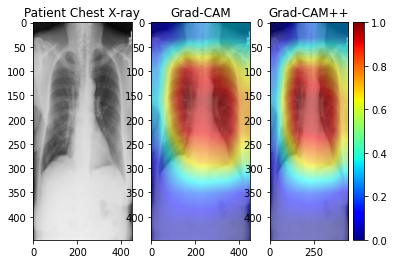

In [ ]:
# Select image n from the dataloader, and send through network to activate neurons in penultimate conv layer
save_cam = True
save_filename = True

n = 2
img = imgs[n,:,:,:].unsqueeze(0).to(device) # get rescaled, ImageNet standardised image from dataloader
lbl, pred_label = gt_labels[n], pred_labels[n] # get nth labels
id, filename = ids[n], filenames[n]            # get nth patients info
print('PatientID: '+str(id))
print('Filename: '+str(filename))
print('True class= '+str(lbl))
print('Pred class= '+str(pred_label))

# if we want to keep this file for running on different models for results  
if save_filename: 
  with open(os.path.join(model_path, 'patient_filenames.txt'), 'a') as filename_txt:
    filename_txt.write('{} {} {}'.format(filename, id, lbl) + '\n')
    filename_txt.close()

# Choose layer to get activations from,
if 'vgg' in model_type.lower():
  selected_layer = 'features_42'
elif 'resnet' in model_type.lower():
    selected_layer = 'layer4'
elif 'densenet' in model_type.lower():
    selected_layer = 'features_norm5'

# Initialise GradCAM(++)
model_dict = dict(model_type=model_type, arch=model, layer_name=selected_layer, input_size=(224, 224))
gradcam = GradCAM(model_dict)
gradcampp = GradCAMpp(model_dict)

# Run images through model
logit = model(img)
mask1, logit1,gradients,activations,weights = gradcam(img, class_idx=pred_label) # get map of predicted class 
mask2, logit2,_ = gradcampp(img, class_idx=pred_label)
prob, index = torch.max(F.softmax(logit2,dim=1), 1)
print(logit)
print(F.softmax(logit,dim=1))

# Manually get the original images loaded by dataloader for using in gradcam 
orig_img_path = os.path.join(img_path, str(filename)) # use img_path from above, and get image with that filename
input_img = imread(orig_img_path)
# Extract original image and resize 
orig_img = cv2.resize(input_img,(input_resize,input_resize))
# Scale pixels between [0,1], and send to np.stacking (see Loading the data)
orig_img = _convertToRGB(orig_img/255) 

# make heatmap from mask and synthesize saliency map using heatmap and the original image 
heatmap1, cam_result1 = visualize_cam(mask1, torch.from_numpy(orig_img).permute(2,0,1).unsqueeze(0))
heatmap2, cam_result2 = visualize_cam(mask2, torch.from_numpy(orig_img).permute(2,0,1).unsqueeze(0))
gradcam_np, gradcampp_np = cam_result1.permute(1,2,0).numpy(), cam_result2.permute(1,2,0).numpy()

# resize images to double input_resize
orig_img = cv2.resize(orig_img,(input_resize*2,input_resize*2))
gradcam_np = cv2.resize(gradcam_np,(input_resize*2,input_resize*2))
gradcampp_np = cv2.resize(gradcampp_np,(input_resize*2,input_resize*2))

# Show cam results
plt.subplot(1, 3, 1).set_title('Patient Chest X-ray')
plt.imshow(orig_img, vmin=0, vmax=1, cmap='jet', aspect='auto')
plt.subplot(1, 3, 2).set_title('Grad-CAM')
plt.imshow(gradcam_np, vmin=0, vmax=1, cmap='jet', aspect='auto')
plt.subplot(1, 3, 3).set_title('Grad-CAM++')
plt.imshow(gradcampp_np, vmin=0, vmax=1, cmap='jet', aspect='auto')
plt.colorbar()
# plt.savefig('epoch30_results/{}').)

# Get folder name from pathology mapping based on prediction lbl
pathology_mapping = { 'normal': 0, 'pneumonia': 1, 'covid': 2 } 
camFolder = list(pathology_mapping.keys())[list(pathology_mapping.values()).index(lbl)]

# Save images as .png to correct folder
if save_cam:
  orig_img_result  = Image.fromarray((orig_img*255).astype(np.uint8)).convert('RGB')
  gradcam_result   = Image.fromarray((gradcam_np*255).astype(np.uint8)).convert('RGB')
  gradcampp_result = Image.fromarray((gradcampp_np*255).astype(np.uint8)).convert('RGB')
  orig_img_result.save(os.path.join(train_train_model_dir,  model_folder, ('epoch30_results/{}').format(camFolder),  ('{}_input_gt={}_pred={}_{}'.format(id,lbl,pred_label,filename))))
  gradcam_result.save(os.path.join(train_train_model_dir,   model_folder, ('epoch30_results/{}').format(camFolder),  ('{}_gradcam_gt={}_pred={}_{}'.format(id,lbl,pred_label,filename))))
  gradcampp_result.save(os.path.join(train_train_model_dir, model_folder, ('epoch30_results/{}').format(camFolder),  ('{}_gradcam++_gt={}_pred={}_{}'.format(id,lbl,pred_label,filename))))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


tensor([[9.9999e-01, 1.3642e-05, 5.0606e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


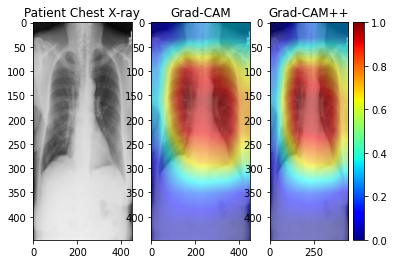

In [ ]:
# Transforms for test images
testTransforms = transforms.Compose([
              Xray_resize(),
              transforms.ToTensor(), 
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),                      
])

# Get a GradCAM saliency map on the class index of interest
csvfile = _process_txt_file(os.path.join(model_path, 'patient_filenames.txt'))
sample = csvfile[13].split()
patientFile = sample[0]
img = imread(os.path.join(img_path, patientFile))
img = _convertToRGB(img)
img_tensor = testTransforms(img).unsqueeze(0).cuda()
id = sample[1]
lbl = int(sample[2])

# Run image through model
logit = model(img_tensor)
mask1, logit1,gradients,activations,weights = gradcam(img_tensor, class_idx=lbl) # get map of predicted class 
mask2, logit2,_ = gradcampp(img_tensor, class_idx=lbl)
prob, index = torch.max(F.softmax(logit2,dim=1), 1)
print(F.softmax(logit,dim=1))

# Extract original image and resize 
orig_img = cv2.resize(img,(input_resize,input_resize))
# Scale pixels between [0,1], and send to np.stacking (see Loading the data)
orig_img = _convertToRGB(orig_img/255) 

# make heatmap from mask and synthesize saliency map using heatmap and the original image 
heatmap1, cam_result1 = visualize_cam(mask1, torch.from_numpy(orig_img).permute(2,0,1).unsqueeze(0))
heatmap2, cam_result2 = visualize_cam(mask2, torch.from_numpy(orig_img).permute(2,0,1).unsqueeze(0))
gradcam_np, gradcampp_np = cam_result1.permute(1,2,0).numpy(), cam_result2.permute(1,2,0).numpy()

# resize images to double input_resize
orig_img = cv2.resize(orig_img,(input_resize*2,input_resize*2))
gradcam_np = cv2.resize(gradcam_np,(input_resize*2,input_resize*2))
gradcampp_np = cv2.resize(gradcampp_np,(input_resize*2,input_resize*2))

# Show cam results
plt.subplot(1, 3, 1).set_title('Patient Chest X-ray')
plt.imshow(orig_img, vmin=0, vmax=1, cmap='jet', aspect='auto')
plt.subplot(1, 3, 2).set_title('Grad-CAM')
plt.imshow(gradcam_np, vmin=0, vmax=1, cmap='jet', aspect='auto')
plt.subplot(1, 3, 3).set_title('Grad-CAM++')
plt.imshow(gradcampp_np, vmin=0, vmax=1, cmap='jet', aspect='auto')
plt.colorbar()
# plt.savefig('epoch30_results/{}').)

# Get folder name from pathology mapping based on prediction lbl
pathology_mapping = { 'normal': 0, 'pneumonia': 1, 'covid': 2 } 
pathology = list(pathology_mapping.keys())[list(pathology_mapping.values()).index(lbl)]

# Save images as .png to correct folder
orig_img_result  = Image.fromarray((orig_img*255).astype(np.uint8)).convert('RGB')
# gradcam_result   = Image.fromarray((gradcam_np*255).astype(np.uint8)).convert('RGB')
gradcampp_result = Image.fromarray((gradcampp_np*255).astype(np.uint8)).convert('RGB')
orig_img_result.save(os.path.join(train_train_model_dir,  model_folder, 'epoch30_results/sup_paper_figs',  ('{}_input_{}.png'.format(id,pathology))))
# gradcam_result.save(os.path.join(train_train_model_dir,   model_folder, 'epoch30_results/paper_figs',('{}_gradcam_{}.png'.format(id,pathology))))
gradcampp_result.save(os.path.join(train_train_model_dir, model_folder, 'epoch30_results/sup_paper_figs',  ('{}_gradcam++_{}_{}.png'.format(id,model_type,pathology))))

Lets have a look at the gradients and outputs from GradCAM

In [ ]:
model_dict = dict(model_type='resnet', arch=model, layer_name='layer4_bottleneck2_bn3', input_size=(224, 224))
gradcam = GradCAM(model_dict)
gradcampp = GradCAMpp(model_dict)
mask1, logit1,gradients,activations,weights = gradcam(img, class_idx=pred_label) # get map of predicted class 
mask2, logit2,_ = gradcampp(img, class_idx=pred_label)

# Lets have a look at these activations 
k=0 # 1st fm
w_fm1 = weights[:,k,:,:]
grad_fm1 = gradients[:,k,:,:]
# conv3_fm_1 = activations[:,k,:,:]
bn_activations_fm1 = activations[:,k,:,:]
x_bn = bn_activations_fm1
x_conv = conv3_fm_1
print(x_conv)
print('mean(var) of x_conv: {} {}'.format(torch.mean(x_conv), torch.var(x_conv)))
print(x_bn)
print('mean(var) of x_bn: {} {}'.format(torch.mean(x_bn), torch.var(x_bn)))

# print(grad_fm1)
# print(w_fm1)

# Do BN process manually
x_hat = torch.div(x_conv-torch.mean(x_conv), torch.std(x_conv)+1e-5)
print('x_hat: \n{}'.format(x_hat))
print('mean(var) of x_hat: {} {}'.format(torch.mean(x_hat), torch.var(x_hat)))

# Now scale and shift to get BN activations
y = torch.mul(torch.std(x_bn),x_hat) + torch.mean(x_bn)
print('y: \n{}'.format(y))
print('mean(var) of my bn (y): {} {}'.format(torch.mean(y), torch.var(y)))
 
# Lets try computing some kind of correlation 
# Nonlinear variables, so use Spearmans 
from scipy.stats import spearmanr
print(x_conv.detach().cpu().numpy().squeeze())
corr,_ = spearmanr(x_conv.detach().cpu().numpy().squeeze(),x_bn.detach().cpu().numpy().squeeze())
print(corr.shape)

In [ ]:
# Select image n from the dataloader 
covid_patients = [1, 6, 8, 27]
n = covid_patients[0]
img = imgs[n,:,:,:].unsqueeze(0).to(device)
lbl, id = lbls[n].numpy(), ids[n]
model_dict = dict(model_type='resnet', arch=model, layer_name='layer4', input_size=(224, 224))
gradcam = GradCAM(model_dict)
gradcampp = GradCAMpp(model_dict)
mask1, logit1, grads, activ, weights = gradcam(img)
mask2, logit2 = gradcampp(img)
print(torch.max(activ))


tensor(10.9255, device='cuda:0', grad_fn=<MaxBackward1>)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


# Balanced dataset experiments
Until now our experiments have utilised the unbalanced COVIDx training dataset, which includes 7966 normal, 5451 pneumonia, and 265 COVID-19 examples. What I'm curious to see is how our fully supervised models perform when we balance the training set to the number of COVID examples (i.e. use 265 cases per class for training), and assign the rest of the images to a separate test set. 
This will enable us to evaluate the performance in response to N training images. Later, I want to be able to set N myself (e.g. train on N=50 images per class) through .input(), but lets get balanceToCovid() working first.

Function requirements:
1.   get number of COVID samples
2.   randomly select N_cov amount of normal and pneumonia samples
3.   send the rest to a new output_dir 

I'd also like to establish a validation dataset within the training set (e.g. 80/20 for train/val), which we can use to perform validation steps during training (i.e. early stopping) and potentially get Stat-CAM to work (i.e. find statistically significant activations according to mean(std) across validation set).



In [ ]:
# Wee helper function to count patients using duplicate id numbers
def countPatients(ids):
  patientCount = 0
  for i in range(0, len(ids)):
    if i==0:
      patientCount += 1
      continue
    if ids[i]==ids[i-1]:
      continue
    else: 
      patientCount += 1
  return patientCount

def count_covids(labels):
  n_covids = 0
  for (i, y) in enumerate(labels):
    if y == 2:
      n_covids += 1 # only count covid images
    else:
      continue
  return n_covids
  
# Load the training dataset using csvfile and image path
img_path, csv_path = train_img_path, train_csv_path # set up paths to training set
csvfile = _process_txt_file(csv_path) 
labels, ids = _convert_labels(csvfile)

# Use the labels to count the COVID images (265)
n_covids = count_covids(labels)

# Now get filenames of all images belonging to each class
X = np.array(ids) 
y = labels 
normal_files = []
pneum_files = []
covid_files = []
for j in range(len(labels)):
  if y[j]==0: # if the label at row j is 'normal'
    normal_files.append(csvfile[j].split()[1])  # append normal_files with filename at that row 
  elif y[j]==1: # if the label at row j is 'pneum'
    pneum_files.append(csvfile[j].split()[1]) 
  elif y[j]==2: # if the label at row j is 'covid'
    covid_files.append(csvfile[j].split()[1]) 

all_files = {'normal': normal_files, 'pneum': pneum_files, 'covid': covid_files}
n_files = [len(all_files[x]) for x in ['normal', 'pneum', 'covid']]

# clunky way: 
# Create lists for storing randomly selected 265 files of each class, 
# and add all lists together at the end to form our balanced dataset.
# TODO: there will be a slicker way to do this, but get it working first.
from numpy.random import default_rng
rng = default_rng()
x_n = [] 
x_p = []
y_list = []
for i in range(n_classes):
  rand_idx = rng.choice(range(n_files[i]), n_covids, replace=False)  # choose unique (ie no duplicates) random instances 
  if i==0:
    [x_n.append(all_files['normal'][j]) for j in rand_idx]
  elif i==1:
    [x_p.append(all_files['pneum'][j]) for j in rand_idx]
  X_list = x_n + x_p + all_files['covid']   # all filenames
  y_list = np.concatenate((np.zeros(n_covids),np.ones(n_covids),np.full(n_covids,2)), axis=None)


# # # for i, file in enumerate(csvfile):
#   sample = file.split()                           
#   filename = sample[1]
#   path_to_img = os.path.join(img_path, filename)     # get image with that filename
#   img = imread(path_to_img)                          
#   X_imgs.append(img) # store that image 

# # Send to balanceToCovid(), which will return dataset of 265 examples per case




265


 # Debugging

In [ ]:
# Need to first replace my layer names with default layer names for Grad-CAM
# First, get names of Resnet layers from state_dict()
# resnet_names = []
# print("Resnet state_dict:")
# for param_tensor in resnet.state_dict():
#     print(param_tensor)
#     resnet_names.append(param_tensor)

# Now iterate through my model, and replace param_tensor from mine with the Resnet one
print("covidClassifier state_dict:")
for param_tensor in model.state_dict():
    # param_tensor.replace(param_tensor, next(iter(resnet_names)))
    print(param_tensor)#, "\t", resnet.state_dict()[param_tensor].size())
 

Unit testing Grad-CAM(++) using ResNet: Test on random image

In [ ]:
from skimage.io import imread 
resnet = torchvision.models.resnet18(pretrained=True)
resnet.eval()
root_path  = 'gdrive/My Drive/Datasets/ChestXray_Datasets/COVIDx_v3/data'   # root to file location in Gdrive
image_path = os.path.join(root_path, 'cats.jpg')
image = imread(image_path)
image.shape
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),                            
    transforms.ToPILImage(),
    transforms.ToTensor(),
]) 
img = transform(image)
# print(img.size())
normaliser = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
norm_img = normaliser(img).unsqueeze(0)
# print(norm_img.size())

# Now fire it through Grad-CAM
model_dict = dict(model_type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
# gradcam = GradCAM(model_dict)
gradcampp = GradCAMpp(model_dict)

# get a GradCAM saliency map on the class index of interest
mask1, logit1 = gradcam(norm_img)
mask2, logit2 = gradcampp(norm_img)

# make heatmap from mask and synthesize saliency map using heatmap and img
heatmap1, cam_result1 = visualize_cam(mask1, img.unsqueeze(0))
heatmap2, cam_result2 = visualize_cam(mask2, img.unsqueeze(0))


TypeError: ignored

Show heatmap

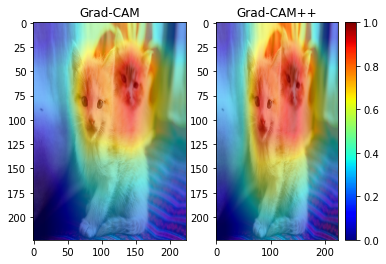

In [ ]:
# Plot subplots
# print(heatmap.shape)
# print(cam_result.shape)
plt.subplot(1, 2, 1).set_title('Grad-CAM')
plt.imshow(cam_result1.permute(1,2,0).numpy(), vmin=0, vmax=1, cmap='jet', aspect='auto')
plt.subplot(1, 2, 2).set_title('Grad-CAM++')
plt.imshow(cam_result2.permute(1,2,0).numpy(), vmin=0, vmax=1, cmap='jet', aspect='auto')
plt.colorbar()

# plt.imshow(heatmap1.permute(1,2,0).numpy())
# plt.imshow(cam_result1.permute(1,2,0).numpy())
# plt.imshow(heatmap2.permute(1,2,0).numpy())
# plt.imshow(cam_result2.permute(1,2,0).numpy())
# plt.colorbar()

In [ ]:
##########################################################################
#                            Supervised models: 
# 1. ResNet-18 
# and
# 2. ResNet-50  
# ------------
# Last layers:
# AdaptiveAvgPool2d: take all 512 FMs for each image in the batch (e.g. [4, 512] for bs=4), 
#                    which are (7x7), and average pool those into 1x1 array. This reduces
#                    our FM size from 7x7 to 1x1 for all 512 FMs for each image.
#                    Thus: input = [4, 512, 7, 7] -> avgpool -> output = [4, 512, 1, 1]
#                    Adaptive since we might not always know input size. Use PyTorch adaptive inferencing to
#                    determine correct kernel and stride sizes for pooling features. 
#
# Linear (Fully connected): after pooling conv features (7x7) to (1x1) score for all 512 Fms, map the 512Fms to 
#                           n_classes to give raw prediction for each class (pre-softmax)

# ------------

# 3. DenseNet-121 
# ------------

# 4. CheXNet
# ------------




##########################################################################

class covidClassifier(nn.Module):
    def __init__(self, in_channels, n_classes, fixed=False):
        super(covidClassifier, self).__init__()
        
        # Choose pretrained model architecture
        #model = torch.hub.load('pytorch/vision:v0.6.0', 'densenet161', pretrained=True) 
        model = models.resnet18(pretrained=True)

        # Fine-tune (fixed=False): update ImageNet weights for all layers, including new FC layer (requires_grad=True)
        # or
        # Fixed feature extractor (fixed=True): freeze entire network weights except our new FC layer,
        # which will be the only weights updated during training (requires_grad=False).
        # Note: params of newly constructed layers will be set to required_grad=True by default. 
        if fixed:
          for param in model.parameters():
            param.requires_grad = False

        # Option to reshape first layer: for telling model how many input channels to expect
#        model.conv1 = torch.nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Option to remove last layers: for reshaping and telling model how many n_classes we want to predict
        num_ftrs = model.fc.in_features
        layer_list = list(model.children())[:-2]
        self.pretrained_model = nn.Sequential(*layer_list)
        self.pooling_layer = nn.AdaptiveAvgPool2d(1)
        self.classifer = nn.Linear(num_ftrs, n_classes)

    def forward(self, x):
        
        features = self.pretrained_model(x)
        pooled_features = self.pooling_layer(features)        
        pooled_features = pooled_features.view(pooled_features.size(0), -1)                
        output = self.classifer(pooled_features)
        #print('image size={}'.format(x.size()))
        #print('output from pretrained layers={}'.format(features.size()))
        #print('pooled_features size={}'.format(pooled_features.size()))

        return output

# Need to rename layer names according to default ResNet names
model = covidClassifier(in_channels, n_classes)
if torch.cuda.is_available():
  model.cuda()
model
# Check various things 
#print(model)                       # have a look under the bonnet
#output_raw = model(images)          # pass batch of images through 
#output_probs = F.softmax(output_raw, dim=1) 
#output_max = torch.max(output_probs, 1)[0] # only return max values, not indices 
#print(output_raw)       # raw predictions (unnormalised/no softmax)
#print(output_probs)     # convert to softmax probs
#print(output_max)
#print(labels)

